# ARIMA Forecasting: Multi-Station Traffic Flow Analysis
This notebook demonstrates ARIMA modeling on traffic flow data from three different freeway stations. We compare forecasting performance across stations and explore short-term prediction capabilities.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv("/full_station_data.csv", parse_dates=["5 Minutes"])
df.head()


,5 Minutes,Lane 1 Flow (Veh/5 Minutes),Lane 1 Occ (%),Lane 2 Flow (Veh/5 Minutes),Lane 2 Occ (%),Lane 3 Flow (Veh/5 Minutes),Lane 3 Occ (%),# Lane Points_x,% Observed_x,Lane 1 Speed (mph),...,Station_ID,Station_Type,Latitude,Longitude,# Lane Points,% Observed,Lane 4 Flow (Veh/5 Minutes),Lane 4 Occ (%),Lane 4 Speed (mph),Lane 4 Q (mph)
0,2024-12-24 23:00:00,88,4.1,143.0,7.3,100.0,6.0,3.0,'0.0,73.6,...,715898,Mainline,33.880149,-118.02173,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-12-24 23:05:00,87,4.1,141.0,7.2,99.0,5.9,3.0,0.0,73.5,...,715898,Mainline,33.880149,-118.02173,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-12-24 23:10:00,87,4.0,141.0,7.1,99.0,5.8,3.0,0.0,73.2,...,715898,Mainline,33.880149,-118.02173,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-12-24 23:15:00,84,4.0,136.0,7.0,96.0,5.7,3.0,0.0,73.3,...,715898,Mainline,33.880149,-118.02173,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-12-24 23:20:00,80,3.7,131.0,6.6,92.0,5.4,3.0,0.0,73.5,...,715898,Mainline,33.880149,-118.02173,NaN,NaN,NaN,NaN,NaN,NaN


## Step 1: Filter and Prepare Data for 3 Mainline Stations
We focus on 3 mainline stations (715898, 716899, 716900). We'll compute total vehicle flow per 5-minute interval.

In [4]:
station_ids = [715898, 716899, 716900]
station_data = {}

for sid in station_ids:
    df_station = df[df["Station_ID"] == sid].copy()
    df_station.set_index("5 Minutes", inplace=True)
    df_station["Total_Flow"] = (
        df_station["Lane 1 Flow (Veh/5 Minutes)"].fillna(0) +
        df_station["Lane 2 Flow (Veh/5 Minutes)"].fillna(0) +
        df_station["Lane 3 Flow (Veh/5 Minutes)"].fillna(0) +
        df_station.get("Lane 4 Flow (Veh/5 Minutes)", pd.Series(0, index=df_station.index)).fillna(0)
    )
    station_data[sid] = df_station


## Step 2: Visualize Time Series for Each Station
This helps understand general flow levels and variations across stations.

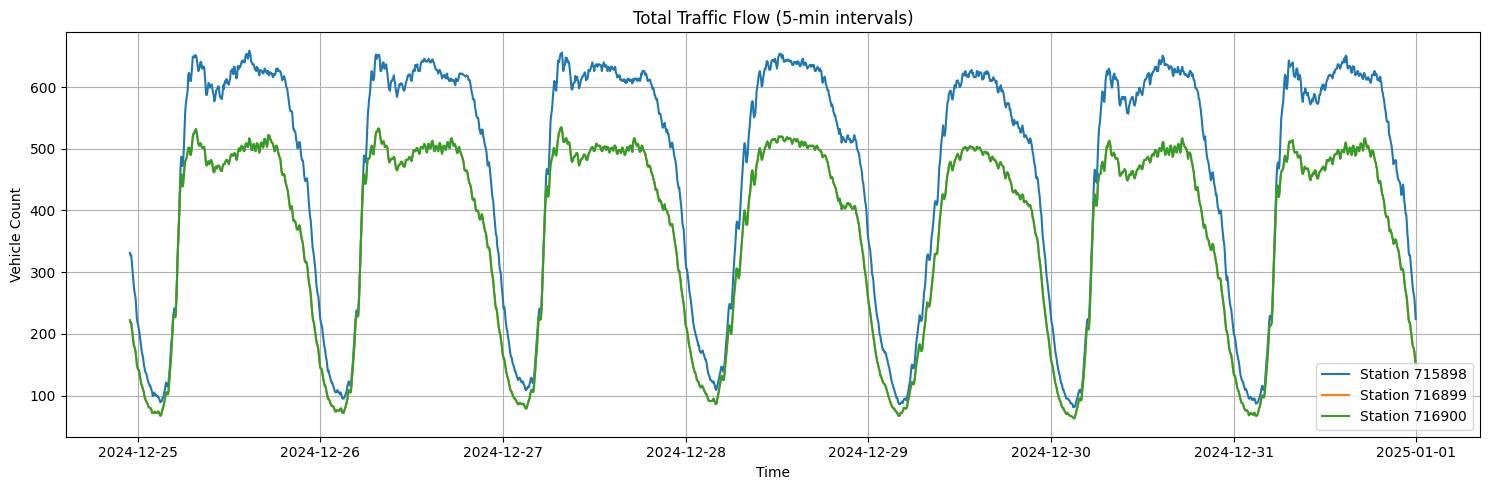

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for sid in station_ids:
    plt.plot(station_data[sid]["Total_Flow"], label=f"Station {sid}")
plt.title("Total Traffic Flow (5-min intervals)")
plt.xlabel("Time")
plt.ylabel("Vehicle Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 3: Apply ARIMA Forecasting (1 Hour Ahead)
We fit an ARIMA(1,1,1) model on each station's flow series and forecast the next 12 intervals (1 hour).

In [6]:
from statsmodels.tsa.arima.model import ARIMA

forecast_horizon = 12
forecast_results = {}

for sid in station_ids:
    series = station_data[sid]["Total_Flow"]
    train = series[:-forecast_horizon]
    test = series[-forecast_horizon:]

    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_horizon)

    forecast_results[sid] = {
        "model": model_fit,
        "forecast": forecast,
        "actual": test
    }


## Step 4: Forecast vs Actual Comparison
We visualize predicted vs actual flow for each station.

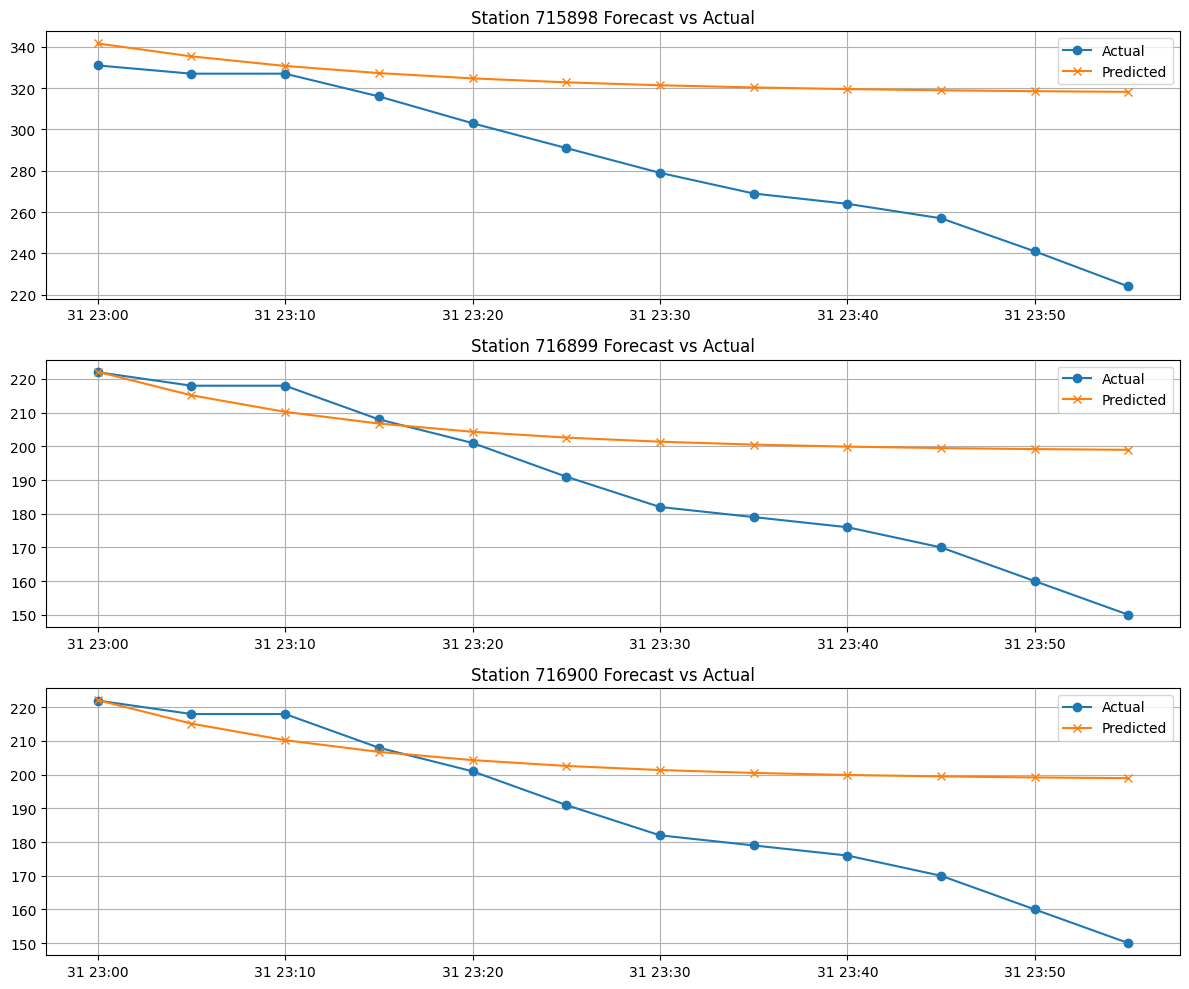

In [7]:
fig, axs = plt.subplots(len(station_ids), 1, figsize=(12, 10))

for i, sid in enumerate(station_ids):
    pred = forecast_results[sid]["forecast"]
    actual = forecast_results[sid]["actual"]

    axs[i].plot(actual.index, actual.values, label="Actual", marker='o')
    axs[i].plot(actual.index, pred.values, label="Predicted", marker='x')
    axs[i].set_title(f"Station {sid} Forecast vs Actual")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()


## Step 5: Evaluate Forecasting Performance
We calculate Mean Absolute Error (MAE) for each station to compare predictive accuracy.

In [8]:
from sklearn.metrics import mean_absolute_error

for sid in station_ids:
    mae = mean_absolute_error(
        forecast_results[sid]["actual"],
        forecast_results[sid]["forecast"]
    )
    print(f"Station {sid} MAE: {mae:.2f}")


Station 715898 MAE: 39.21
Station 716899 MAE: 17.44
Station 716900 MAE: 17.44
